In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import os
import json
import seaborn as sns
import warnings
from scipy import stats

In [2]:
# seeding
np.random.seed(0)

In [3]:
import sys
sys.path.insert(0, '../src/data')

from data_loader import load_config, load_data

config = load_config()
data_path = config['data_path']
df = load_data(data_path)

In [4]:
# count amount of unique ids for each lab
lab_counts = df['lab'].value_counts()
print(lab_counts)

lab
3.0    885404
1.0    619534
5.0    194307
2.0    184500
4.0     74546
Name: count, dtype: int64


In [5]:
# number of unique combinations of lab and mouseIDs
number_of_unique_combinations = df.groupby(['lab', 'mouseID']).ngroups
number_of_unique_combinations

150

In [6]:
# unique id, L{lab}, M{mouseID}
df['unique_id'] = df['lab'].astype(str) + '_' + df['mouseID'].astype(str)
df['unique_id'] = df['unique_id'].astype('category').cat.codes + 1
df = df.sort_values('unique_id')
df

,slowdelta,fastdelta,slowtheta,fasttheta,alpha,beta,rms,mouseID,lab,sleepstage,epoch,unique_id
0,0.286260,0.175425,0.207455,0.125388,0.108024,0.058404,0.338769,1.0,1.0,3.0,1.0,1
41184,0.090378,0.370615,0.240097,0.081554,0.140792,0.067703,0.414360,1.0,1.0,3.0,43255.0,1
41185,0.411872,0.127013,0.172795,0.062764,0.082301,0.047648,0.406009,1.0,1.0,3.0,43256.0,1
41186,0.260672,0.200171,0.164967,0.081898,0.154101,0.060435,0.418746,1.0,1.0,3.0,43257.0,1
41187,0.162809,0.091261,0.266165,0.132450,0.177477,0.041848,0.412606,1.0,1.0,3.0,43258.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1879140,0.337924,0.231237,0.068860,0.054589,0.092746,0.072120,0.109166,9.0,5.0,3.0,7178.0,150
1879139,0.307003,0.264140,0.142889,0.045048,0.051583,0.073142,0.663739,9.0,5.0,3.0,7177.0,150
1879138,0.404338,0.274106,0.076717,0.036097,0.089673,0.053889,0.103816,9.0,5.0,3.0,7176.0,150
1879146,0.164438,0.372611,0.219474,0.050206,0.135191,0.061387,0.105354,9.0,5.0,3.0,7184.0,150


In [7]:
# Mapping sleep stages to names
df['sleepstage_name'] = df['sleepstage'].map({1: 'Wake', 2: 'NREM', 3: 'REM'})

# EEG features
eeg_features = ['slowdelta', 'fastdelta', 'slowtheta', 'fasttheta', 'alpha', 'beta', 'rms']

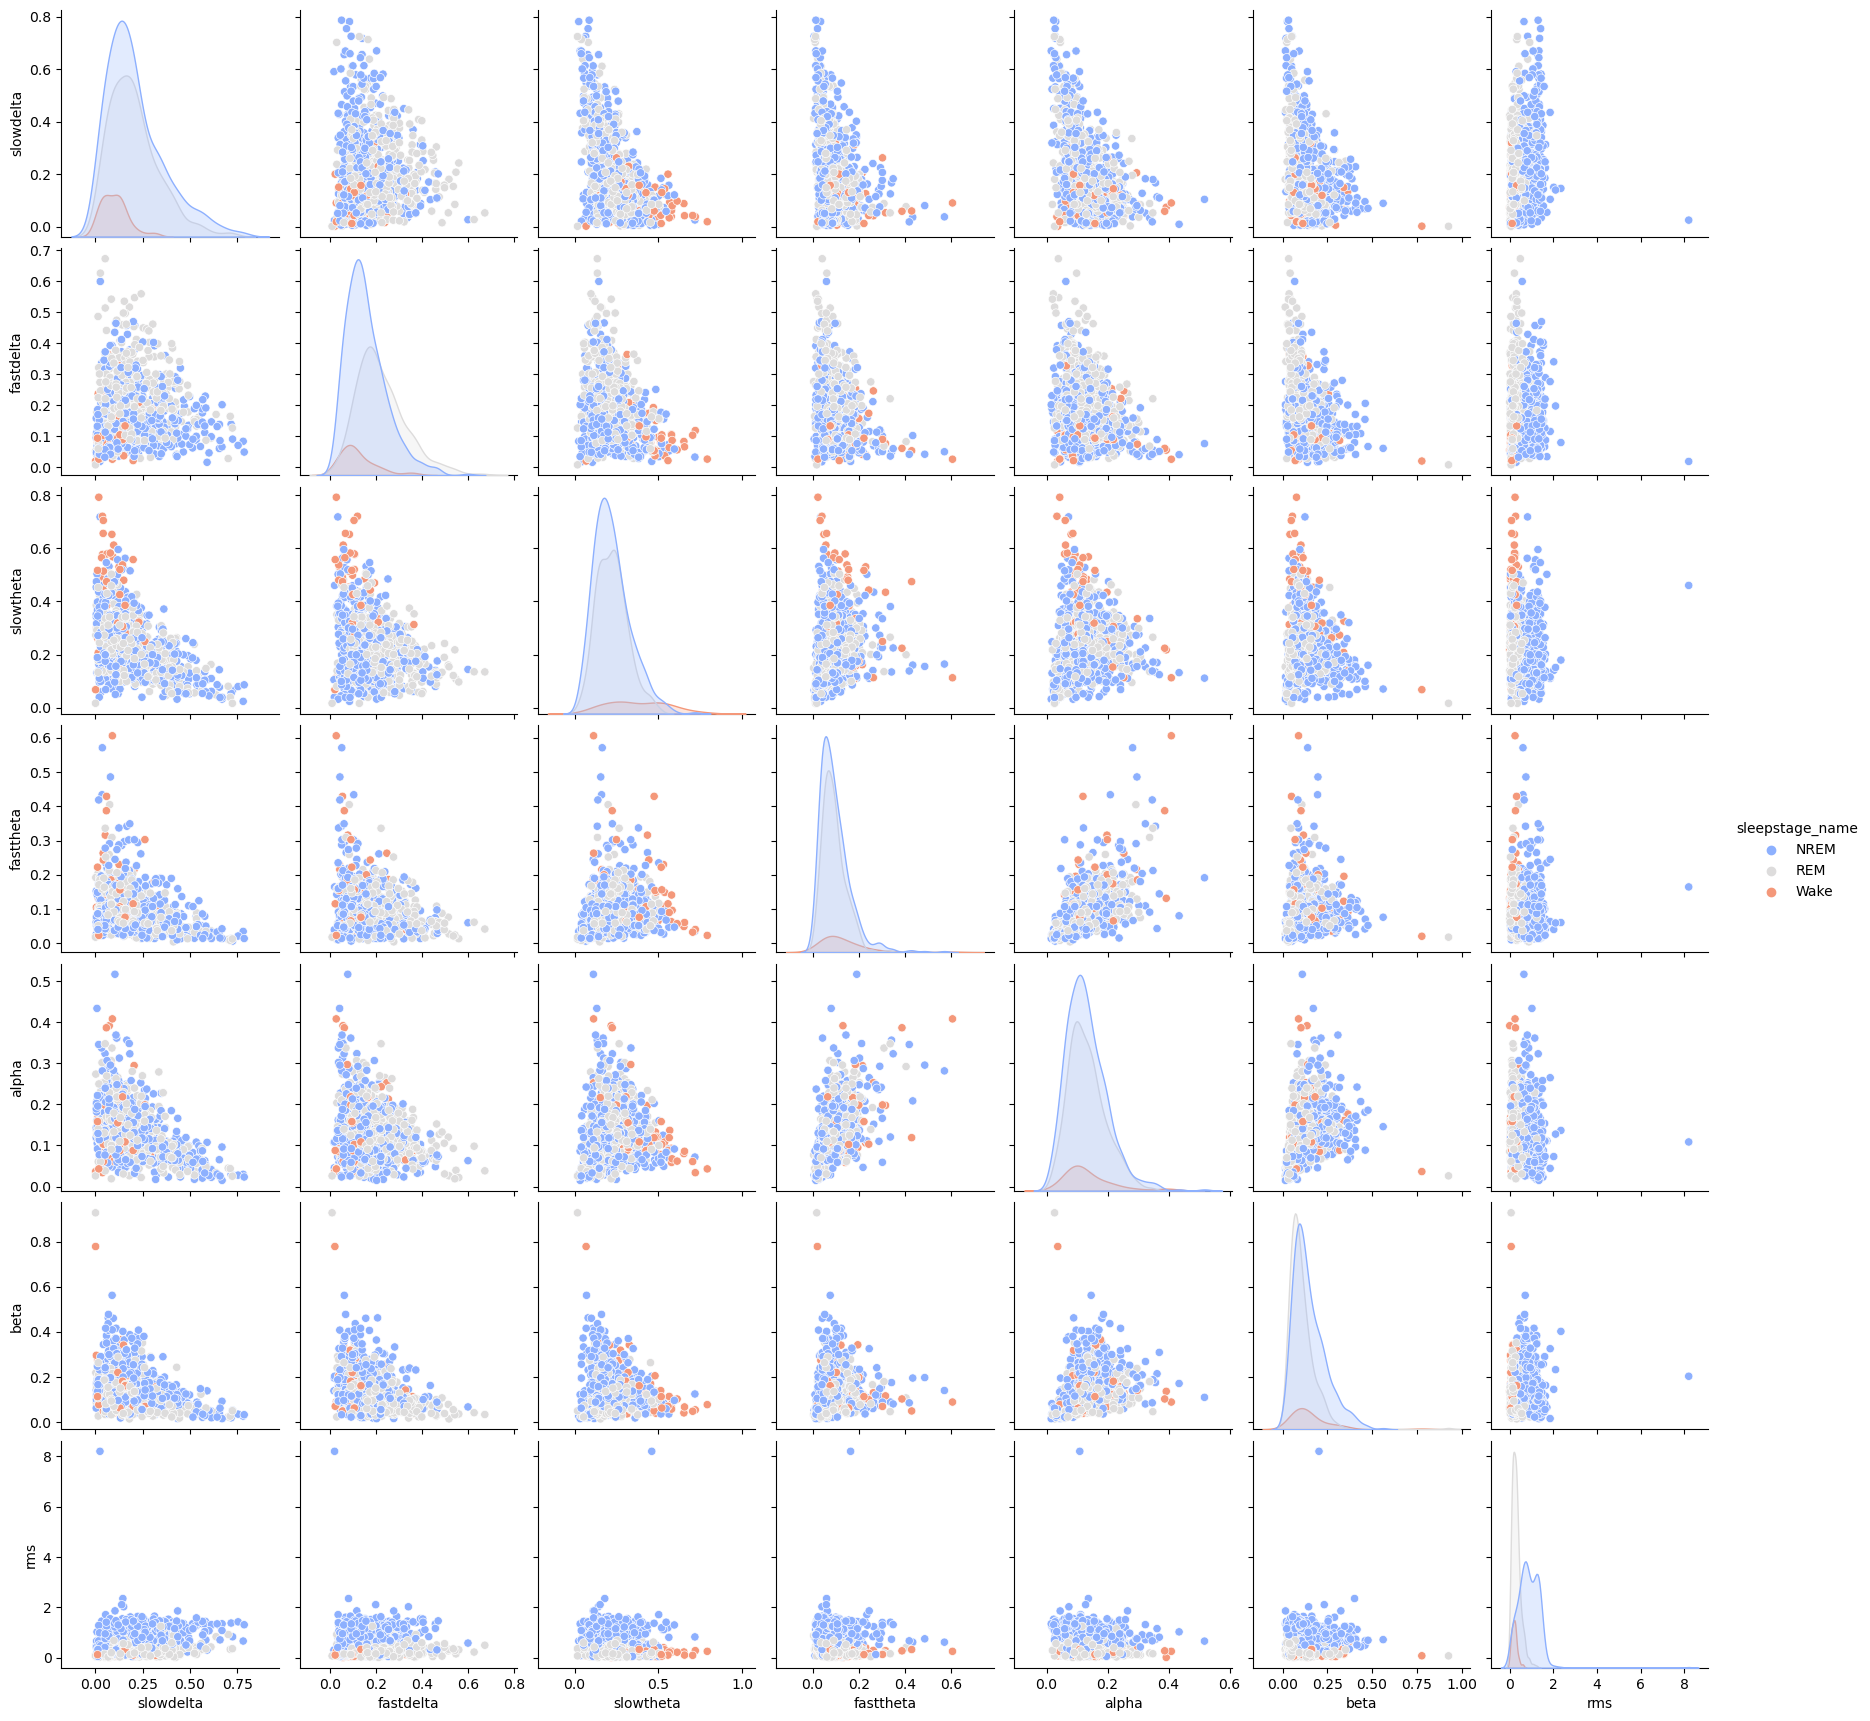

In [8]:
# Ignore warnings
warnings.filterwarnings('ignore')

# Your existing code
sampled_df = df.sample(n=1000, random_state=42)  # Adjust n as needed

# Create a pair plot
sns.pairplot(sampled_df, vars=['slowdelta', 'fastdelta', 'slowtheta', 'fasttheta', 'alpha', 'beta', 'rms'], 
             hue='sleepstage_name', palette='coolwarm')

# Show the plot
plt.show()

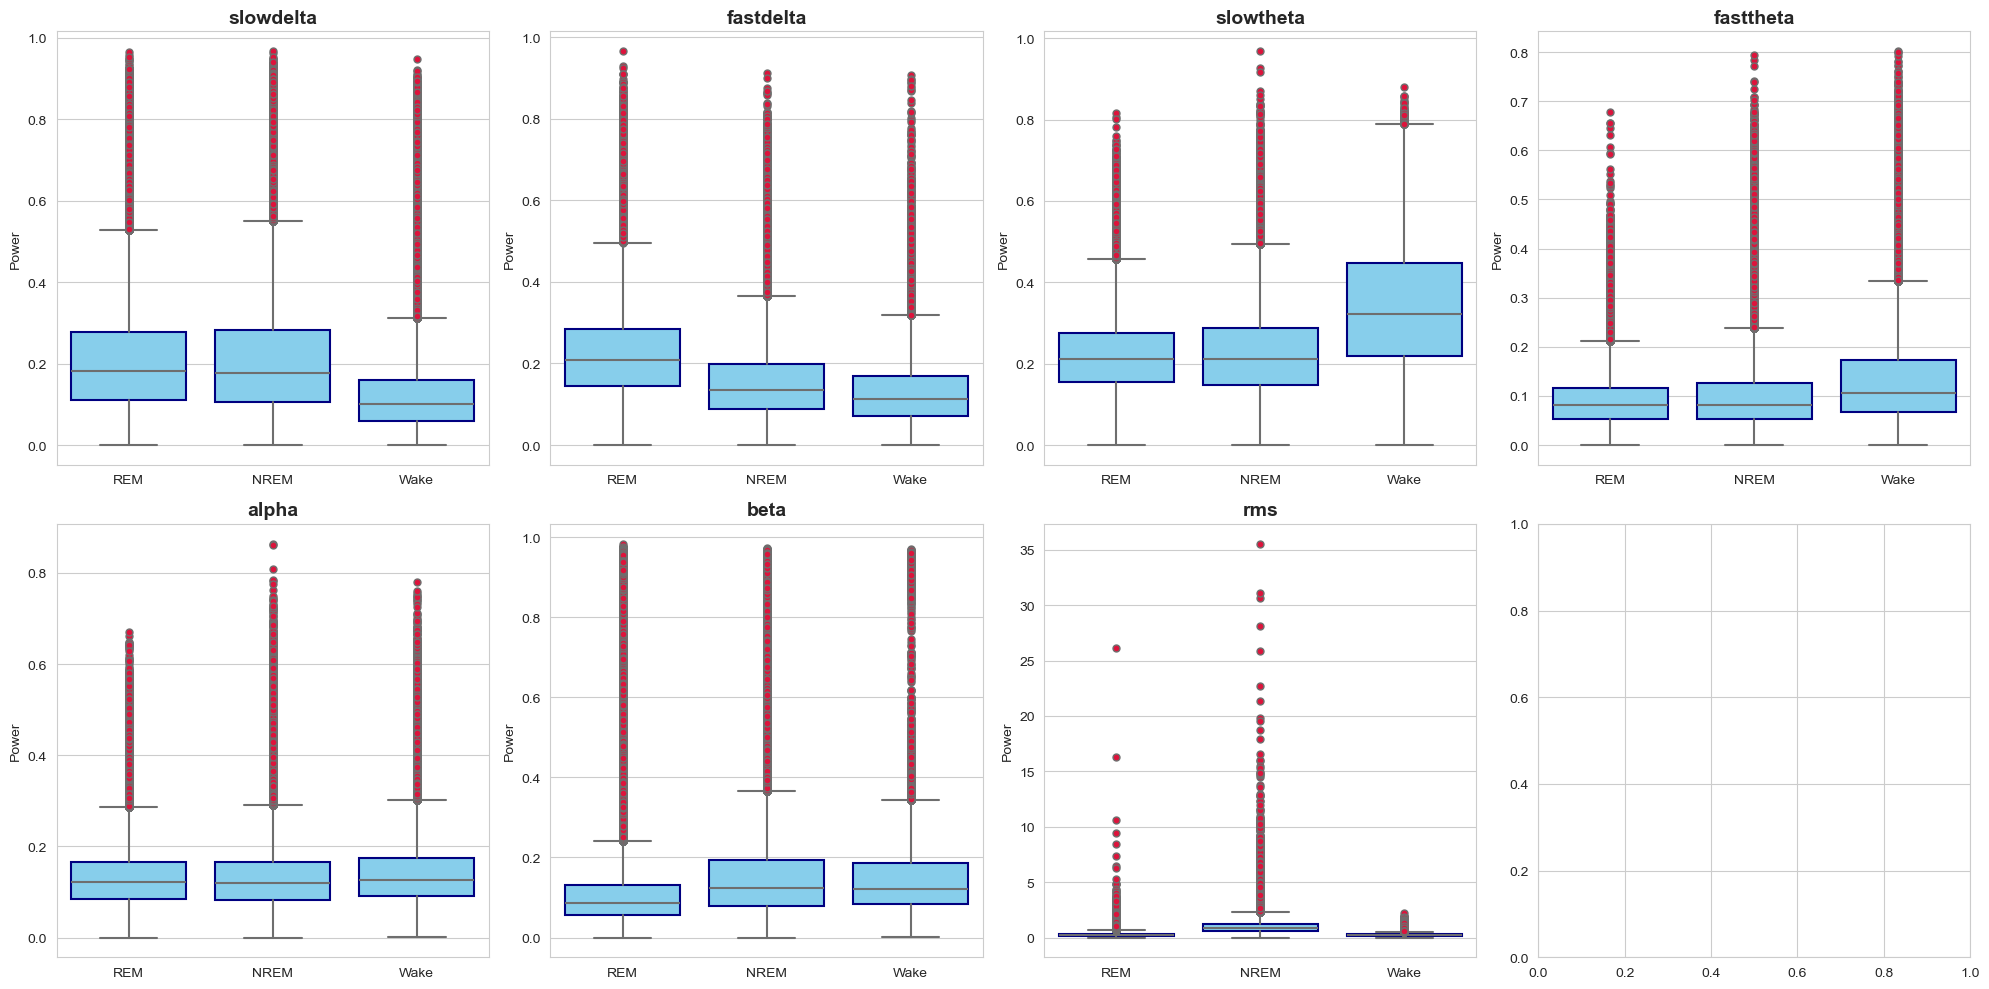

In [9]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Set up the matplotlib figure and axes
fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # Adjust the size as needed
axes = axes.flatten()

# Define color palette and properties for box and fliers
palette = sns.color_palette("coolwarm", len(df['sleepstage_name'].unique()))
boxprops = dict(facecolor='skyblue', edgecolor='navy')
flierprops = dict(markerfacecolor='crimson', marker='o', markersize=5)

# Iterate over each EEG feature to create a boxplot for each
for ax, feature in zip(axes, eeg_features):
    sns.boxplot(x='sleepstage_name', y=feature, data=df, ax=ax,
                palette=palette, boxprops=boxprops, flierprops=flierprops)

    # Set title and labels
    ax.set_title(feature, fontsize=14, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('Power')

# Adjust layout and show plot
plt.tight_layout()
plt.show()

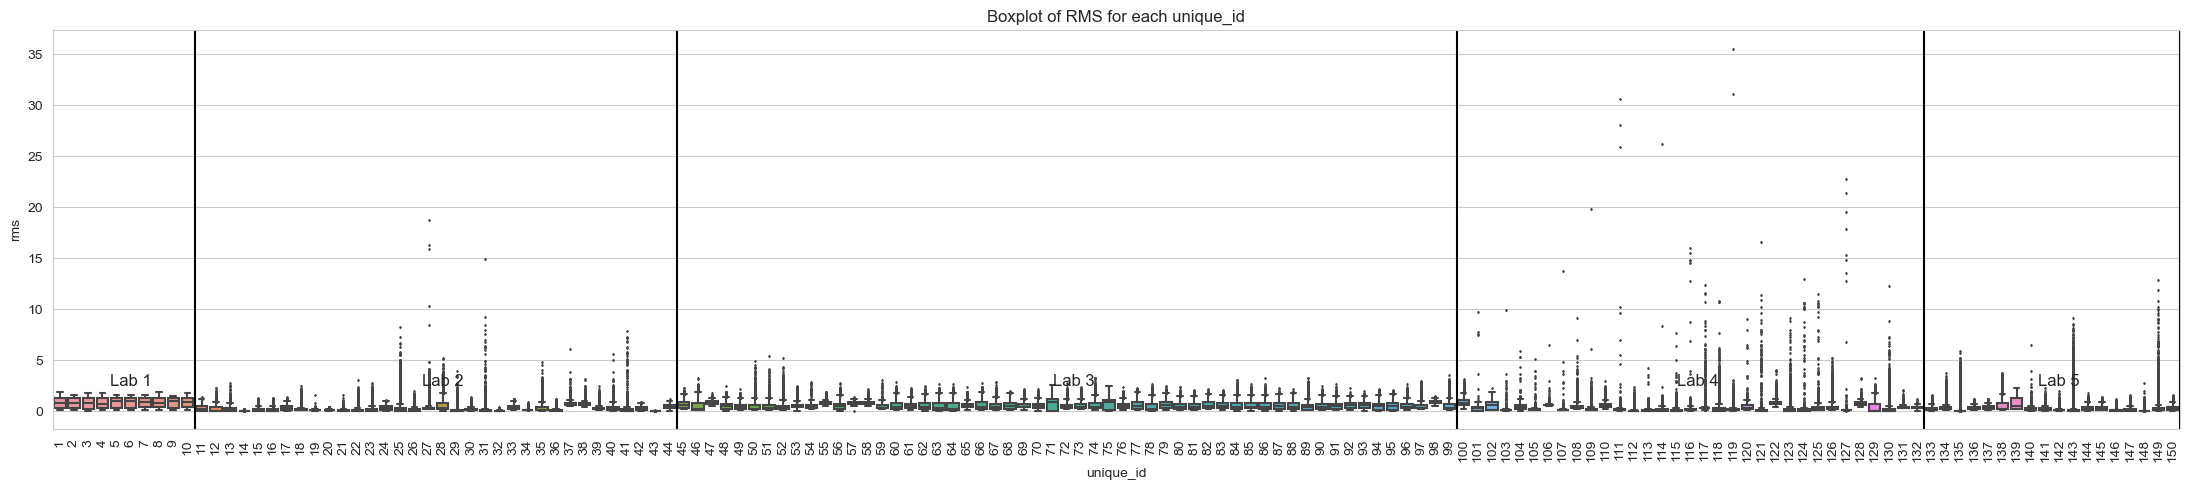

In [10]:
plt.figure(figsize=(22, 5))
sns.boxplot(x='unique_id', y='rms', data=df, fliersize=1)
labindex = np.array(df.groupby('lab')['mouseID'].nunique())
labindex_cum = np.cumsum(labindex)
for i in range(len(labindex_cum)):
    plt.axvline(labindex_cum[i]-0.5, color='black', linestyle='-')
    plt.text(labindex_cum[i]-labindex[i]/2, 2.5, 'Lab ' + str(i+1), fontsize=12, ha='center')
plt.title('Boxplot of RMS for each unique_id')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [11]:
# remove RMS outliers from each unique_id
for i in df['unique_id'].unique():
    # get the index of the unique_id
    index = df[df['unique_id'] == i].index
    # get the z-score of the RMS for the unique_id
    z = np.abs(stats.zscore(df.loc[index, 'rms']))
    # remove the outliers
    df = df.drop(index[np.where(z > 3)[0]])

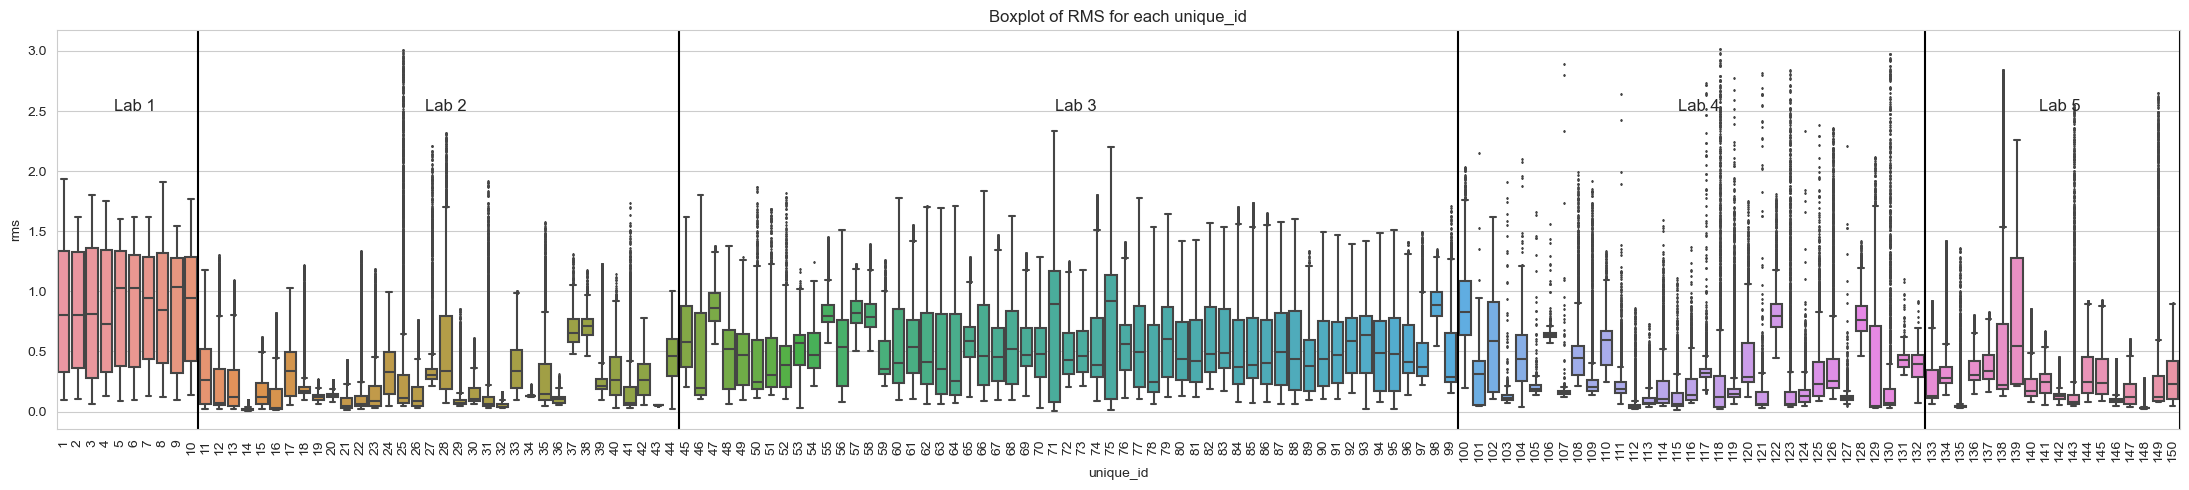

In [12]:
# Create the boxplot
plt.figure(figsize=(22, 5))
bplot = sns.boxplot(x='unique_id', y='rms', data=df, fliersize=1)

# Set box color and edge color
for box in bplot.artists:
    box.set_facecolor('skyblue')
    box.set_edgecolor('navy')

# Add vertical lines and lab text
labindex = np.array(df.groupby('lab')['mouseID'].nunique())
labindex_cum = np.cumsum(labindex)
for i in range(len(labindex_cum)):
    plt.axvline(labindex_cum[i]-0.5, color='black', linestyle='-')
    plt.text(labindex_cum[i]-labindex[i]/2, 2.5, 'Lab ' + str(i+1), fontsize=12, ha='center')

# Set title and labels
plt.title('Boxplot of RMS for each unique_id')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

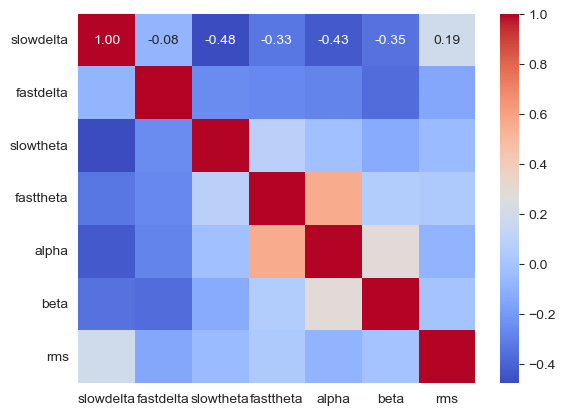

In [15]:
# Calculate the correlation matrix
corr = df[['slowdelta', 'fastdelta', 'slowtheta', 'fasttheta', 'alpha', 'beta', 'rms']].corr()

# Create a heatmap
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')

# Show the plot
plt.show()

# sleep stages
# 1 = wake 
# 2 = NREM
# 3 = REM

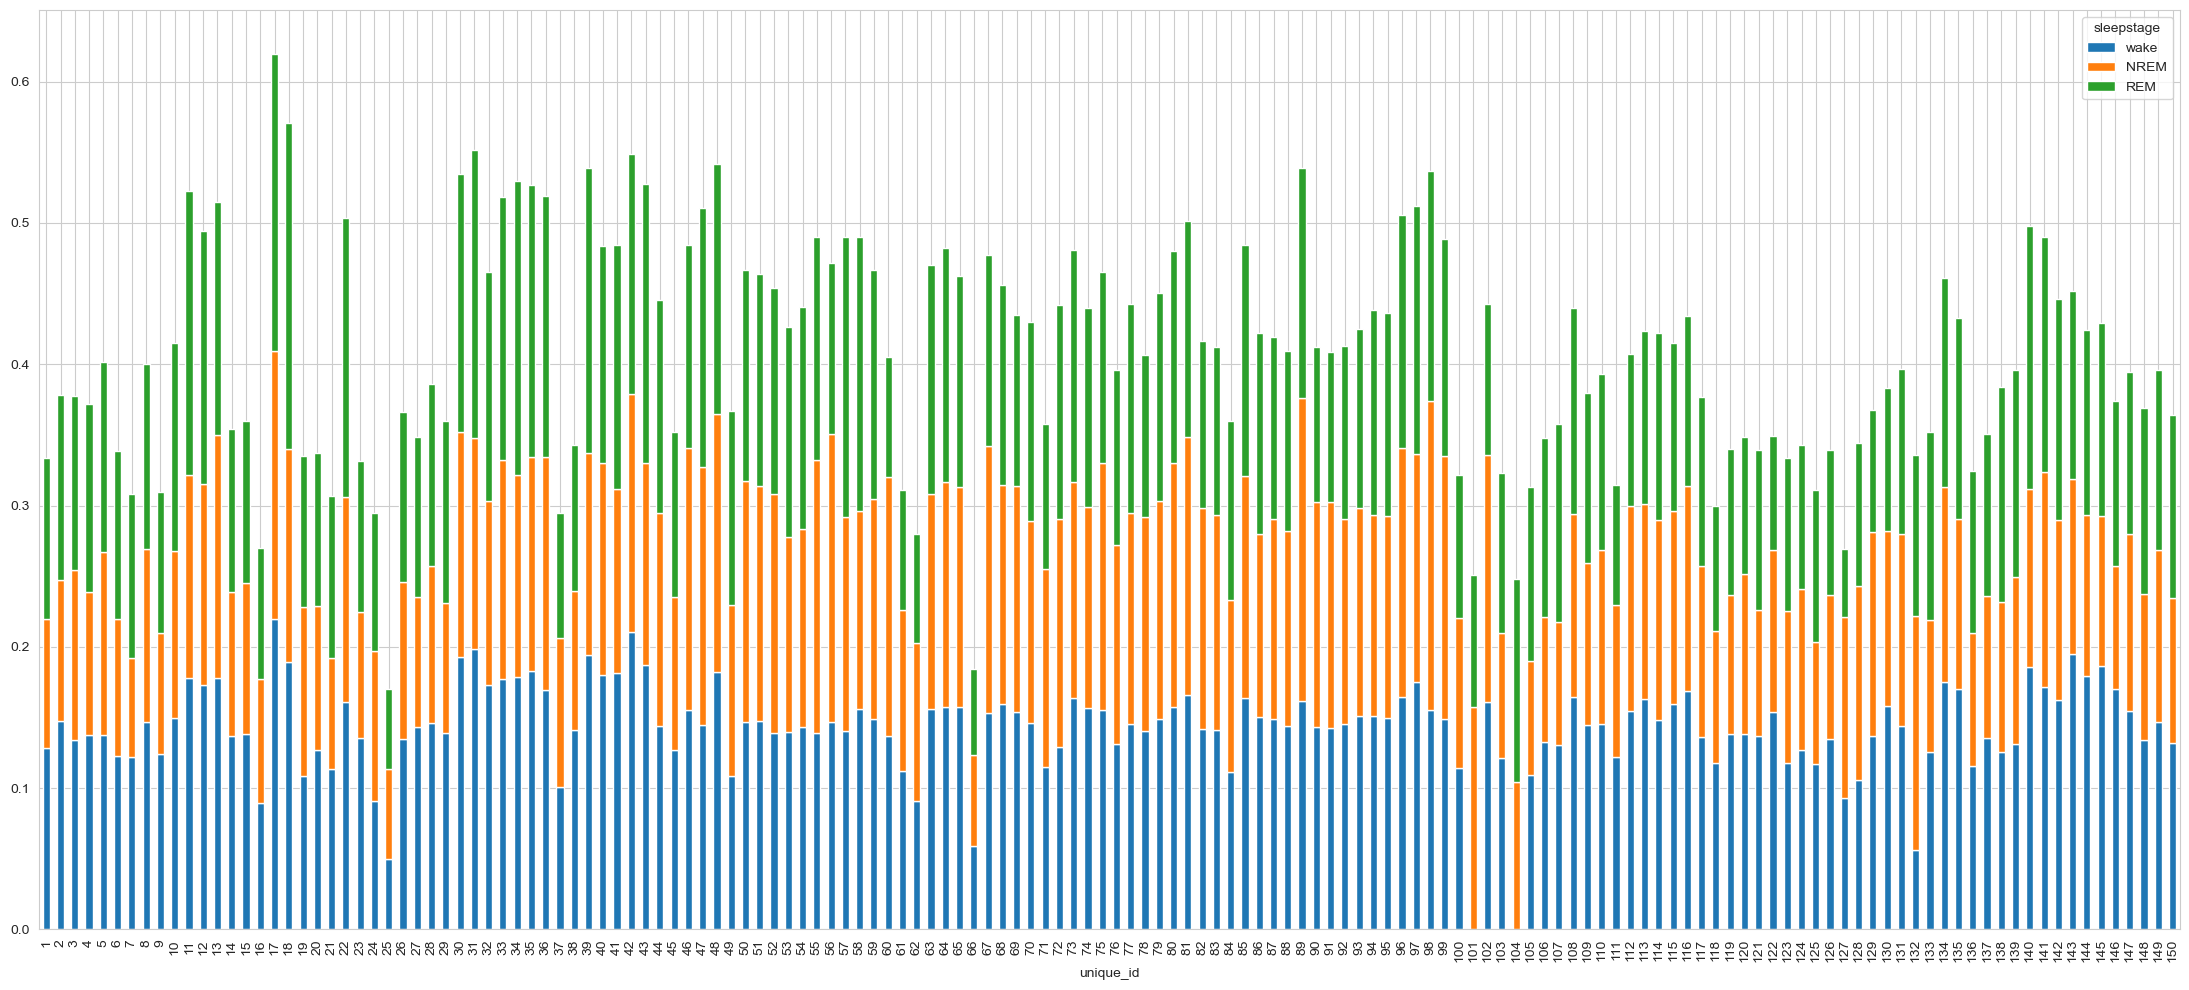

In [16]:
import matplotlib.pyplot as plt

# define a dictionary to map sleep stage numbers to names
sleep_stages = {1: 'wake', 2: 'NREM', 3: 'REM'}

mean_alpha_by_id = df.groupby(['unique_id', 'sleepstage'])['alpha'].mean().unstack().fillna(0)
mean_alpha_by_id.rename(columns=sleep_stages, inplace=True)
mean_alpha_by_id.plot(kind='bar', stacked=True)

# make plot wider
plt.gcf().set_size_inches(22, 10)
plt.tight_layout()
plt.show()